In [3]:

from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [11]:
# ================================
# 📂 FraudPulse EDA + Preprocessing
# ================================

# ✅ 1. Imports
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Display settings for notebook
pd.set_option('display.max_columns', None)

In [12]:
# ✅ 2. Load Raw Data
fraud_data = pd.read_csv('/content/drive/MyDrive/FraudPulse/data/raw/Fraud_Data.csv')
ip_data = pd.read_csv('/content/drive/MyDrive/FraudPulse/data/raw/IpAddress_to_Country.csv')

print("✅ Loaded Fraud_Data:", fraud_data.shape)
print("✅ Loaded IP Data:", ip_data.shape)

# ✅ 3. Basic Info
print(fraud_data.info())
print(fraud_data.head())

✅ Loaded Fraud_Data: (151112, 11)
✅ Loaded IP Data: (138846, 3)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151112 entries, 0 to 151111
Data columns (total 11 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         151112 non-null  int64  
 1   signup_time     151112 non-null  object 
 2   purchase_time   151112 non-null  object 
 3   purchase_value  151112 non-null  int64  
 4   device_id       151112 non-null  object 
 5   source          151112 non-null  object 
 6   browser         151112 non-null  object 
 7   sex             151112 non-null  object 
 8   age             151112 non-null  int64  
 9   ip_address      151112 non-null  float64
 10  class           151112 non-null  int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 12.7+ MB
None
   user_id          signup_time        purchase_time  purchase_value  \
0    22058  2015-02-24 22:55:49  2015-04-18 02:47:11              34   
1   333320  201

Fraud class distribution:
 class
0    0.906354
1    0.093646
Name: proportion, dtype: float64


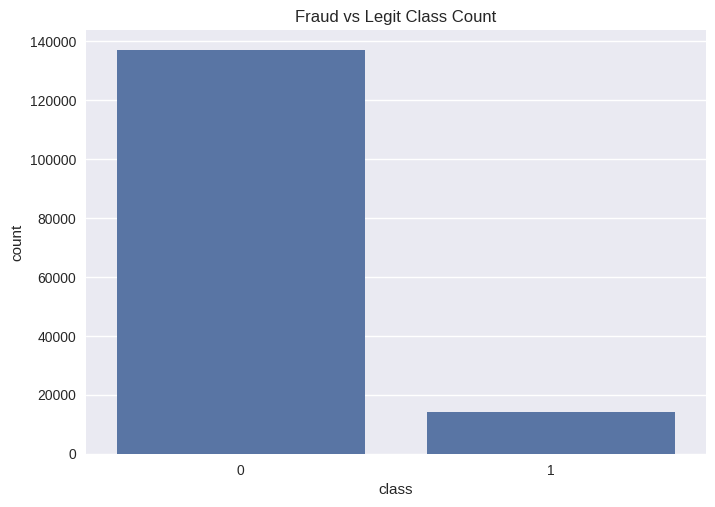

In [13]:
# ✅ 4. Class Distribution
class_dist = fraud_data['class'].value_counts(normalize=True)
print("Fraud class distribution:\n", class_dist)

# ✅ 5. EDA: Class Count Plot
sns.countplot(data=fraud_data, x='class')
plt.title("Fraud vs Legit Class Count")
plt.show()

In [14]:
# ✅ 6. Convert IP Address for Join
fraud_data['ip_int'] = fraud_data['ip_address'].astype(int)

# ✅ 7. Join IP to Country
def map_ip_to_country(ip):
    row = ip_data[
        (ip_data['lower_bound_ip_address'] <= ip) &
        (ip_data['upper_bound_ip_address'] >= ip)
    ]
    if not row.empty:
        return row.iloc[0]['country']
    else:
        return 'Other'

fraud_data['country'] = fraud_data['ip_int'].apply(map_ip_to_country)

print("Countries found:", fraud_data['country'].nunique())


Countries found: 182


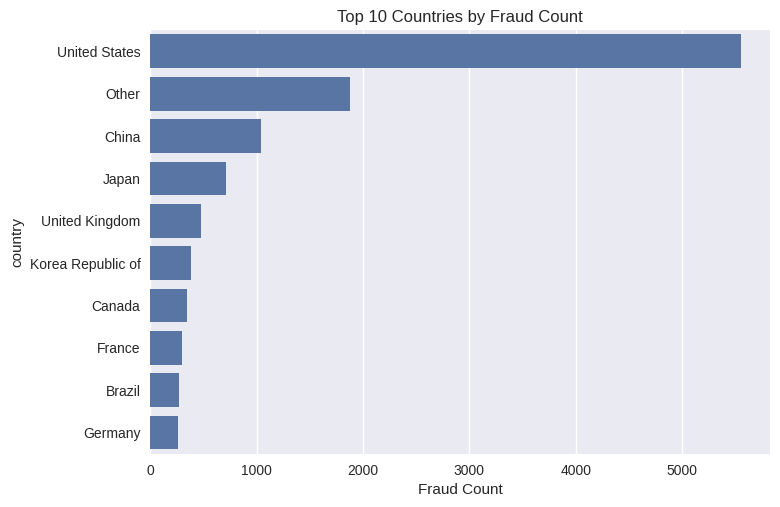

In [15]:
# ✅ 8. EDA: Top Fraud Countries
top_countries = fraud_data[fraud_data['class'] == 1]['country'].value_counts().head(10)
sns.barplot(y=top_countries.index, x=top_countries.values)
plt.title("Top 10 Countries by Fraud Count")
plt.xlabel("Fraud Count")
plt.show()

# ✅ 9. Timestamps to Datetime
fraud_data['signup_time'] = pd.to_datetime(fraud_data['signup_time'])
fraud_data['purchase_time'] = pd.to_datetime(fraud_data['purchase_time'])

In [16]:
# ✅ 10. Feature Engineering
fraud_data['time_since_signup'] = (fraud_data['purchase_time'] - fraud_data['signup_time']).dt.total_seconds()
fraud_data['hour_of_day'] = fraud_data['purchase_time'].dt.hour
fraud_data['day_of_week'] = fraud_data['purchase_time'].dt.day_name()

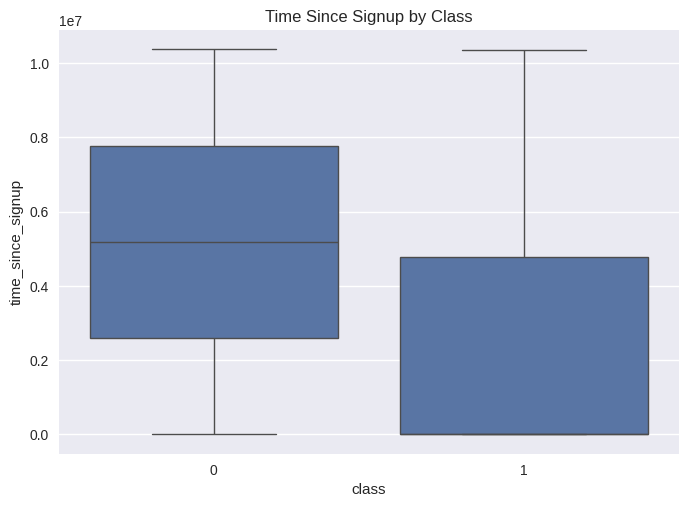

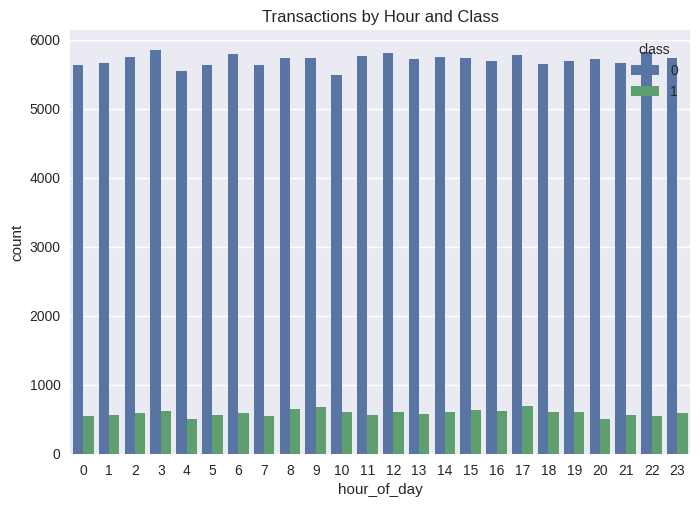

In [17]:
# ✅ 11. EDA: Fraud by Time Since Signup
sns.boxplot(data=fraud_data, x='class', y='time_since_signup')
plt.title("Time Since Signup by Class")
plt.show()

# ✅ 12. EDA: Fraud by Hour of Day
sns.countplot(data=fraud_data, x='hour_of_day', hue='class')
plt.title("Transactions by Hour and Class")
plt.show()

In [18]:
# ✅ 13. Add transaction count per user
fraud_data['transaction_count'] = fraud_data.groupby('user_id')['user_id'].transform('count')

# ✅ 14. Basic Cleaning
print("Duplicates:", fraud_data.duplicated().sum())
print("Missing:\n", fraud_data.isnull().sum())


Duplicates: 0
Missing:
 user_id              0
signup_time          0
purchase_time        0
purchase_value       0
device_id            0
source               0
browser              0
sex                  0
age                  0
ip_address           0
class                0
ip_int               0
country              0
time_since_signup    0
hour_of_day          0
day_of_week          0
transaction_count    0
dtype: int64


In [19]:
# ✅ 15. Encode Categorical
fraud_data_encoded = pd.get_dummies(
    fraud_data,
    columns=['sex', 'source', 'browser', 'country', 'day_of_week'],
    drop_first=False
)

# ✅ 16. Scale Numeric
num_cols = ['purchase_value', 'age', 'time_since_signup', 'transaction_count']
scaler = StandardScaler()
fraud_data_encoded[num_cols] = scaler.fit_transform(fraud_data_encoded[num_cols])

print(fraud_data_encoded[num_cols].describe())


       purchase_value           age  time_since_signup  transaction_count
count    1.511120e+05  1.511120e+05       1.511120e+05           151112.0
mean     4.006184e-17  8.614235e-17      -1.034461e-16                0.0
std      1.000003e+00  1.000003e+00       1.000003e+00                0.0
min     -1.524632e+00 -1.756930e+00      -1.577617e+00                0.0
25%     -8.151294e-01 -7.125683e-01      -8.781362e-01                0.0
50%     -1.056270e-01 -1.632727e-02      -1.818071e-03                0.0
75%      6.584524e-01  6.799138e-01       8.676506e-01                0.0
max      6.389048e+00  4.973400e+00       1.738805e+00                0.0


In [20]:
# ✅ 17. Check Class Imbalance
print("Class imbalance:\n", fraud_data_encoded['class'].value_counts())

# ✅ 18. SMOTE to Handle Imbalance — just for demonstration
X = fraud_data_encoded.drop(['class', 'signup_time', 'purchase_time', 'device_id', 'ip_address'], axis=1)
y = fraud_data_encoded['class']

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

print("After SMOTE:", y_resampled.value_counts())

# ✅ 19. Save Processed
processed = pd.concat([X, y], axis=1)
processed.to_csv('/content/drive/MyDrive/FraudPulse/data/processed/fraud_data_processed.csv', index=False)
print("✅ Processed fraud data saved.")

Class imbalance:
 class
0    136961
1     14151
Name: count, dtype: int64
After SMOTE: class
0    136961
1    136961
Name: count, dtype: int64
✅ Processed fraud data saved.
